In [1]:
%pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.datasets import imdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from konlpy.tag import Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 모델 생성
import tensorflow.keras as keras
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input
import tensorflow.keras.models as models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.layers as layers

In [3]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=20000)

In [4]:
print(f"훈련 데이터: {len(X_train)}")
print(f"검증(테스트) 데이터: {len(X_test)}")
num_classes = len(set(Y_train))
print(f"카테고리: {num_classes}")

훈련 데이터: 25000
검증(테스트) 데이터: 25000
카테고리: 2


In [5]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [6]:
max([max(sequence) for sequence in X_train])

19999

In [7]:
from keras.models import load_model
from keras.layers import Lambda
import tensorflow as tf

In [8]:
word_to_idx = tf.keras.datasets.imdb.get_word_index()
idx_to_word = dict([(value, key) for (key, value) in word_to_idx.items()])
decoded_review = ' '.join([idx_to_word.get(i) for i in X_train[0]])
print(decoded_review)

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then

In [9]:
def vectorize_sequences(sequences, dimension=20000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
       results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)
print(X_train.shape)
print(X_test.shape)

(25000, 20000)
(25000, 20000)


In [10]:
Y_train = np.array(Y_train).astype('float32')
Y_test = np.array(Y_test).astype('float32')

In [11]:
max_features = 20000 # 가장 빈번하게 사용된 5000개의 단어만 사용
maxlen = 500 # 각 시퀀스의 최대 길이
(X_train, Y_train), (X_test, Y_test) = keras.datasets.imdb.load_data(num_words=max_features)
# 시퀀스의 길이를 maxlen으로 변경해줌(maxlen보다 짧았으면, 0으로 채워준다)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

## Word Embedding layer를 이용한 Dense model1

In [12]:
model1 = models.Sequential(
[layers.Embedding(20000, 64, input_length=maxlen),
layers.Flatten(),
layers.Dense(1, activation='sigmoid')])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           1280000   
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 1)                 32001     
                                                                 
Total params: 1,312,001
Trainable params: 1,312,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model1.fit(X_train, Y_train,
epochs=10,
batch_size=64,
validation_split=0.3)

Epoch 1/10
274/274 [==============================] - 4s 15ms/step - loss: 0.5444 - acc: 0.7162 - val_loss: 0.3399 - val_acc: 0.8616
Epoch 2/10
274/274 [==============================] - 4s 15ms/step - loss: 0.2175 - acc: 0.9225 - val_loss: 0.2797 - val_acc: 0.8860
Epoch 3/10
274/274 [==============================] - 4s 15ms/step - loss: 0.0953 - acc: 0.9770 - val_loss: 0.2813 - val_acc: 0.8896
Epoch 4/10
274/274 [==============================] - 4s 15ms/step - loss: 0.0405 - acc: 0.9950 - val_loss: 0.2920 - val_acc: 0.8888
Epoch 5/10
274/274 [==============================] - 4s 15ms/step - loss: 0.0190 - acc: 0.9990 - val_loss: 0.3104 - val_acc: 0.8852
Epoch 6/10
274/274 [==============================] - 4s 15ms/step - loss: 0.0106 - acc: 0.9997 - val_loss: 0.3230 - val_acc: 0.8885
Epoch 7/10
274/274 [==============================] - 4s 16ms/step - loss: 0.0064 - acc: 0.9999 - val_loss: 0.3366 - val_acc: 0.8869
Epoch 8/10
274/274 [==============================] - 4s 15ms/step - 

In [14]:
#sigmoid 10000,32, batch_size=128
'''
Epoch 1/10
157/157 [==============================] - 2s 14ms/step - loss: 0.6308 - acc: 0.6414 - val_loss: 0.4587 - val_acc: 0.8152
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.3258 - acc: 0.8787 - val_loss: 0.3098 - val_acc: 0.8758
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2055 - acc: 0.9290 - val_loss: 0.2883 - val_acc: 0.8830
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1417 - acc: 0.9578 - val_loss: 0.2924 - val_acc: 0.8846
Epoch 5/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0959 - acc: 0.9778 - val_loss: 0.2965 - val_acc: 0.8814
Epoch 6/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0631 - acc: 0.9900 - val_loss: 0.3086 - val_acc: 0.8804
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.0422 - acc: 0.9959 - val_loss: 0.3223 - val_acc: 0.8768
Epoch 8/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0287 - acc: 0.9983 - val_loss: 0.3356 - val_acc: 0.8758
Epoch 9/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0202 - acc: 0.9992 - val_loss: 0.3497 - val_acc: 0.8766
Epoch 10/10
157/157 [==============================] - 2s 13ms/step - loss: 0.0149 - acc: 0.9995 - val_loss: 0.3619 - val_acc: 0.8754
'''

'\nEpoch 1/10\n157/157 [==============================] - 2s 14ms/step - loss: 0.6308 - acc: 0.6414 - val_loss: 0.4587 - val_acc: 0.8152\nEpoch 2/10\n157/157 [==============================] - 2s 14ms/step - loss: 0.3258 - acc: 0.8787 - val_loss: 0.3098 - val_acc: 0.8758\nEpoch 3/10\n157/157 [==============================] - 2s 14ms/step - loss: 0.2055 - acc: 0.9290 - val_loss: 0.2883 - val_acc: 0.8830\nEpoch 4/10\n157/157 [==============================] - 2s 14ms/step - loss: 0.1417 - acc: 0.9578 - val_loss: 0.2924 - val_acc: 0.8846\nEpoch 5/10\n157/157 [==============================] - 2s 13ms/step - loss: 0.0959 - acc: 0.9778 - val_loss: 0.2965 - val_acc: 0.8814\nEpoch 6/10\n157/157 [==============================] - 2s 13ms/step - loss: 0.0631 - acc: 0.9900 - val_loss: 0.3086 - val_acc: 0.8804\nEpoch 7/10\n157/157 [==============================] - 2s 12ms/step - loss: 0.0422 - acc: 0.9959 - val_loss: 0.3223 - val_acc: 0.8768\nEpoch 8/10\n157/157 [==============================]

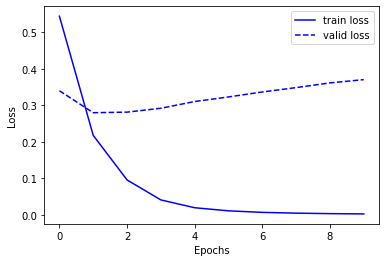

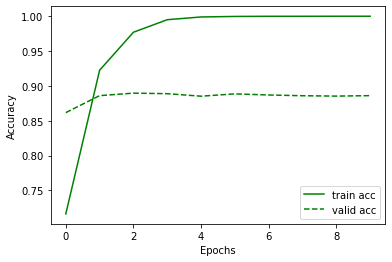

In [15]:
#그래프 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b-', label='train loss')
plt.plot(history.history['val_loss'], 'b--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


plt.plot(history.history['acc'], 'g-', label='train acc')
plt.plot(history.history['val_acc'], 'g--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
model1.evaluate(X_test, Y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.4150 - acc: 0.8651


[0.4149598777294159, 0.8650799989700317]

### SimpleRNN layer model2

In [17]:
max_features = 5000 # 가장 빈번하게 사용된 5000개의 단어만 사용
maxlen = 500 # 각 시퀀스의 최대 길이
(X_train, Y_train), (X_test, Y_test) = keras.datasets.imdb.load_data(num_words=max_features)
# 시퀀스의 길이를 maxlen으로 변경해줌(maxlen보다 짧았으면, 0으로 채워준다)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

In [18]:
model2 = models.Sequential(
[layers.Embedding(max_features, 1000),
layers.SimpleRNN(64),
layers.Dense(32, activation='softmax'),
layers.Dropout(0.2),
layers.Dense(1, activation='sigmoid')]
)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 1000)        5000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                68160     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,070,273
Trainable params: 5,070,273
Non-trainable params: 0
_________________________________________________________________


In [19]:
r = model1.fit(X_train, Y_train,
epochs=10,
batch_size=64,
validation_split=0.2)

Epoch 1/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0859 - acc: 0.9737 - val_loss: 0.3980 - val_acc: 0.8682
Epoch 2/10
313/313 [==============================] - 5s 14ms/step - loss: 0.0131 - acc: 0.9993 - val_loss: 0.4121 - val_acc: 0.8694
Epoch 3/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0062 - acc: 0.9999 - val_loss: 0.4282 - val_acc: 0.8686
Epoch 4/10
313/313 [==============================] - 5s 14ms/step - loss: 0.0042 - acc: 0.9999 - val_loss: 0.4423 - val_acc: 0.8702
Epoch 5/10
313/313 [==============================] - 5s 14ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.4561 - val_acc: 0.8698
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4693 - val_acc: 0.8692
Epoch 7/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.4817 - val_acc: 0.8692
Epoch 8/10
313/313 [==============================] - 5s 15ms/step - 

In [20]:
#sigmoid 5000,500, batch_size=64
'''
Epoch 1/10
274/274 [==============================] - 8s 28ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3873 - val_acc: 0.8828
Epoch 2/10
274/274 [==============================] - 7s 27ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3939 - val_acc: 0.8840
Epoch 3/10
274/274 [==============================] - 7s 27ms/step - loss: 9.4417e-04 - acc: 1.0000 - val_loss: 0.4031 - val_acc: 0.8845
Epoch 4/10
274/274 [==============================] - 8s 28ms/step - loss: 7.5166e-04 - acc: 1.0000 - val_loss: 0.4109 - val_acc: 0.8831
Epoch 5/10
274/274 [==============================] - 7s 27ms/step - loss: 5.9703e-04 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8835
Epoch 6/10
274/274 [==============================] - 7s 27ms/step - loss: 4.8367e-04 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.8828
Epoch 7/10
274/274 [==============================] - 8s 27ms/step - loss: 3.9593e-04 - acc: 1.0000 - val_loss: 0.4358 - val_acc: 0.8828
Epoch 8/10
274/274 [==============================] - 7s 26ms/step - loss: 3.2646e-04 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.8840
Epoch 9/10
274/274 [==============================] - 7s 27ms/step - loss: 2.6959e-04 - acc: 1.0000 - val_loss: 0.4516 - val_acc: 0.8824
Epoch 10/10
274/274 [==============================] - 7s 27ms/step - loss: 2.2508e-04 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 0.8819
'''

'\nEpoch 1/10\n274/274 [==============================] - 8s 28ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3873 - val_acc: 0.8828\nEpoch 2/10\n274/274 [==============================] - 7s 27ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3939 - val_acc: 0.8840\nEpoch 3/10\n274/274 [==============================] - 7s 27ms/step - loss: 9.4417e-04 - acc: 1.0000 - val_loss: 0.4031 - val_acc: 0.8845\nEpoch 4/10\n274/274 [==============================] - 8s 28ms/step - loss: 7.5166e-04 - acc: 1.0000 - val_loss: 0.4109 - val_acc: 0.8831\nEpoch 5/10\n274/274 [==============================] - 7s 27ms/step - loss: 5.9703e-04 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8835\nEpoch 6/10\n274/274 [==============================] - 7s 27ms/step - loss: 4.8367e-04 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.8828\nEpoch 7/10\n274/274 [==============================] - 8s 27ms/step - loss: 3.9593e-04 - acc: 1.0000 - val_loss: 0.4358 - val_acc: 0.8828\nEpoch 8/10\n274/274 [===========

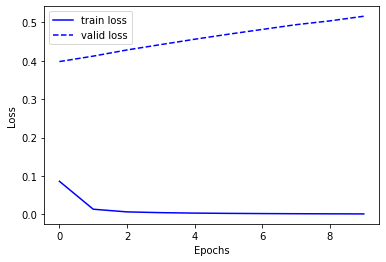

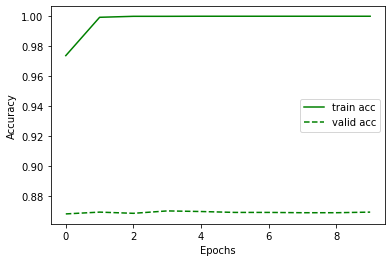

In [21]:
#그래프 
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], 'b-', label='train loss')
plt.plot(r.history['val_loss'], 'b--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


plt.plot(r.history['acc'], 'g-', label='train acc')
plt.plot(r.history['val_acc'], 'g--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model2.evaluate(X_test, Y_test)

782/782 [==============================] - 53s 68ms/step - loss: 0.6932 - acc: 0.5003


[0.6931757926940918, 0.5003200173377991]

### LSTM layer model3

In [27]:
model3 = models.Sequential(
[layers.Embedding(max_features, 500),
layers.LSTM(64),
layers.Dense(1, activation='sigmoid')]
)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 500)         2500000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                144640    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,644,705
Trainable params: 2,644,705
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint("review_model.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [29]:
r = model3.fit(X_train, Y_train, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6918 - acc: 0.5080
Epoch 1: val_acc improved from -inf to 0.51600, saving model to review_model.h5
625/625 [==============================] - 132s 210ms/step - loss: 0.6918 - acc: 0.5080 - val_loss: 0.6877 - val_acc: 0.5160
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.6744 - acc: 0.5202
Epoch 2: val_acc improved from 0.51600 to 0.52040, saving model to review_model.h5
625/625 [==============================] - 131s 210ms/step - loss: 0.6744 - acc: 0.5202 - val_loss: 0.6882 - val_acc: 0.5204
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.6515 - acc: 0.5367
Epoch 3: val_acc did not improve from 0.52040
625/625 [==============================] - 132s 212ms/step - loss: 0.6515 - acc: 0.5367 - val_loss: 0.7023 - val_acc: 0.5112
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.6398 - acc: 0.5415
Epoch 4: val_acc did not improve from 0.52040
625/62

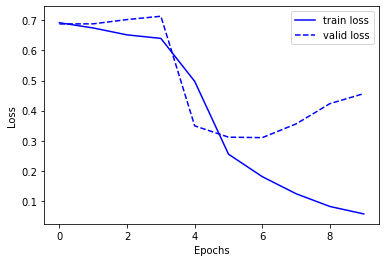

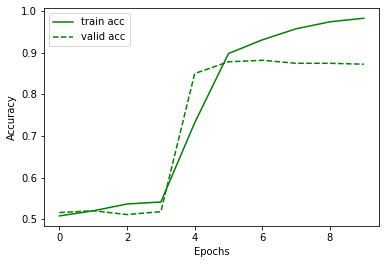

In [30]:
#그래프 
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], 'b-', label='train loss')
plt.plot(r.history['val_loss'], 'b--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


plt.plot(r.history['acc'], 'g-', label='train acc')
plt.plot(r.history['val_acc'], 'g--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
model3.evaluate(X_test, Y_test)

782/782 [==============================] - 50s 63ms/step - loss: 0.4708 - acc: 0.8662


[0.47076937556266785, 0.8662400245666504]

### GRU layer model4

In [36]:
model4 = models.Sequential(
[layers.Embedding(5000, 100),
layers.GRU(128),
layers.Dense(1, activation='sigmoid')]
)
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         500000    
                                                                 
 gru_4 (GRU)                 (None, 128)               88320     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 588,449
Trainable params: 588,449
Non-trainable params: 0
_________________________________________________________________


In [37]:
r = model4.fit(X_train, Y_train,
epochs=10,
batch_size=64,
validation_split=0.3)

Epoch 1/10
274/274 [==============================] - 106s 382ms/step - loss: 0.6927 - acc: 0.5029 - val_loss: 0.6921 - val_acc: 0.5127
Epoch 2/10
274/274 [==============================] - 105s 382ms/step - loss: 0.6855 - acc: 0.5114 - val_loss: 0.6901 - val_acc: 0.5013
Epoch 3/10
274/274 [==============================] - 106s 386ms/step - loss: 0.7547 - acc: 0.5166 - val_loss: 0.6990 - val_acc: 0.4952
Epoch 4/10
274/274 [==============================] - 106s 388ms/step - loss: 0.6872 - acc: 0.5183 - val_loss: 0.6913 - val_acc: 0.5037
Epoch 5/10
274/274 [==============================] - 109s 398ms/step - loss: 0.6783 - acc: 0.5468 - val_loss: 0.6830 - val_acc: 0.5592
Epoch 6/10
274/274 [==============================] - 110s 401ms/step - loss: 0.6568 - acc: 0.6000 - val_loss: 0.6320 - val_acc: 0.6532
Epoch 7/10
274/274 [==============================] - 110s 400ms/step - loss: 0.5127 - acc: 0.7542 - val_loss: 0.4993 - val_acc: 0.7632
Epoch 8/10
274/274 [============================

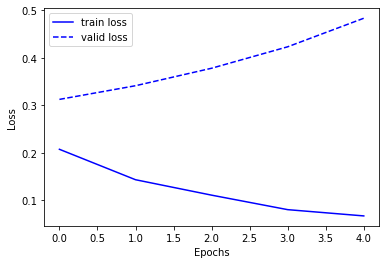

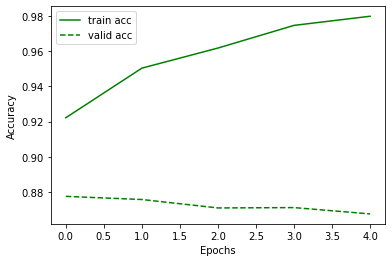

In [42]:
#그래프 
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], 'b-', label='train loss')
plt.plot(r.history['val_loss'], 'b--', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


plt.plot(r.history['acc'], 'g-', label='train acc')
plt.plot(r.history['val_acc'], 'g--', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint("review_model.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [41]:
r1 = model4.fit(X_train, Y_train, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.2071 - acc: 0.9222
Epoch 1: val_acc improved from -inf to 0.87740, saving model to review_model.h5
625/625 [==============================] - 113s 179ms/step - loss: 0.2071 - acc: 0.9222 - val_loss: 0.3122 - val_acc: 0.8774
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.1431 - acc: 0.9504
Epoch 2: val_acc did not improve from 0.87740
625/625 [==============================] - 112s 179ms/step - loss: 0.1431 - acc: 0.9504 - val_loss: 0.3410 - val_acc: 0.8756
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.1106 - acc: 0.9618
Epoch 3: val_acc did not improve from 0.87740
625/625 [==============================] - 112s 179ms/step - loss: 0.1106 - acc: 0.9618 - val_loss: 0.3778 - val_acc: 0.8708
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.0800 - acc: 0.9747
Epoch 4: val_acc did not improve from 0.87740
625/625 [==============================] - 

In [45]:
model4.evaluate(X_test, Y_test)

782/782 [==============================] - 40s 51ms/step - loss: 0.5054 - acc: 0.8556


[0.5053685307502747, 0.8555999994277954]